In [1]:
import math
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from accelerate import Accelerator

from preprocessor import load_and_preprocess, decoding, process_data
from qwen import load_qwen

import numpy as np

import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from preprocessor import get_dataset

import wandb
import joblib

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

import torchtune

import gc

from flopper import Flopper

torch.cuda.empty_cache()

/home/ljf1/dis/lora/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [2]:
#for matplotlib plots
SMALL_SIZE = 15+5
MEDIUM_SIZE = 20+5
BIGGER_SIZE = 25+5

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [3]:
# Define constants
batch_size = 4
test_size = 0.2
max_steps = 200
max_ctx_length = 512
points = 80

# Define parameter grid
lora_ranks = [2, 4, 8]
learning_rates = [1e-5, 5e-5, 1e-4]

lora_rank = lora_ranks[1]
learning_rate = learning_rates[2]

lora_alpha = 2*lora_rank

In [4]:
# Define LoRA layers
class LoRALinear(nn.Module):
    def __init__(self, original_linear: nn.Linear, r: int, alpha: int = None):
        super().__init__()
        assert isinstance(original_linear, nn.Linear)
        self.original_linear = original_linear
        self.original_linear.weight.requires_grad = False
        if self.original_linear.bias is not None:
            self.original_linear.bias.requires_grad = False
        in_dim = original_linear.in_features
        out_dim = original_linear.out_features
        self.r = r
        self.alpha = alpha if alpha else r

        device = original_linear.weight.device
        self.A = nn.Parameter(torch.empty(r, in_dim, device=device))
        self.B = nn.Parameter(torch.zeros(out_dim, r, device=device))
        
        # Initialise A with He initialization
        nn.init.kaiming_normal_(self.A, nonlinearity="linear")

    def forward(self, x):
        base_out = self.original_linear(x)
        lora_out = (x @ self.A.T) @ self.B.T
        return base_out + lora_out * (self.alpha / self.r)

In [5]:
# Load the model and tokenizer
model, tokenizer = load_qwen()

In [6]:
# Process the data into sequences of text
train_texts, val_texts, test_texts = load_and_preprocess("lotka_volterra_data.h5", test_size=test_size)

# ^Each of these is a `list[str]` representing contiguous parts of the time series,
#  in text form (using the LLMTIME scheme).

# Modified tokenization with chunking
def process_sequences(texts, tokenizer, max_length=512, stride=256):
    all_input_ids = []
    for text in texts:
        # Apply Qwen's tokenization scheme to the text:
        encoding = tokenizer(text, return_tensors="pt", add_special_tokens=False, padding_side='left')
        seq_ids = encoding.input_ids[0]

        # Create sliding windows to further divide the data into chunks:
        for i in range(0, len(seq_ids), stride):
            chunk = seq_ids[i : i + max_length]
            if len(chunk) < max_length:
                chunk = torch.cat(
                    [
                        torch.full((max_length - len(chunk),), tokenizer.pad_token_id),
                        chunk,
                    ]
                )
            all_input_ids.append(chunk)
    return torch.stack(all_input_ids)

# Process the testing data into sequences of text as well as input IDs
def process_data(texts, tokenizer, points=80):
    """
    Process the data into sequences of text
    
    Args:
        texts: list of original strings
        tokenizer: tokenizer object
        points: number of points to give to the model
        
    Returns:
        np.array: texts
        torch.Tensor: given_input_ids
    """
    given_input_ids = []
    for text in texts:
        given_text = ';'.join([chunk for i, chunk in enumerate(text.split(';')) if i < points])
        encoding_given = tokenizer(given_text, return_tensors="pt", padding='max_length', padding_side='left', max_length=1200)
        given_input_ids.append(encoding_given.input_ids[0])
    return np.stack([text for text in texts]), torch.stack(given_input_ids)

def running_mse(prediction, actual):
    """
    Calculate the running mean squared error.

    Args:
        prediction: list of predicted values
        actual: list of actual values

    Returns:
        np.array: running mean squared error
    """
    mse = []
    for i in range(len(prediction)):
        mse.append(mean_squared_error(prediction[:i+1], actual[:i+1]))
    return np.array(mse)

def evaluate_model(model, val_loader, step):
    """
    Evaluate the model on the validation set.
    
    Args:
        model: model to evaluate
        val_loader: validation data loader
        step: current step

    Returns:
        float: average loss on the validation set
    """
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch_idx, (batch,) in enumerate(tqdm(val_loader, desc="val set")):
            outputs = model(batch, labels=batch)
            loss = outputs.loss
            total_loss += loss.item()
            
    # Calculate metrics
    num_batches = len(val_loader)
    avg_loss = total_loss / len(val_loader)
    print(f'Loss on validation subset ({num_batches}/{len(val_loader)} batches) at step {step}: {avg_loss:.4f}')
    return avg_loss

# Defines the maximum context length for the model
train_input_ids = process_sequences(
    train_texts, tokenizer, max_ctx_length, stride=max_ctx_length // 2
)
val_input_ids = process_sequences(
    val_texts, tokenizer, max_ctx_length, stride=max_ctx_length
)
test_texts_all, test_input_ids_some = process_data(
    test_texts, tokenizer, points=points
)

In [7]:
# Create data loaders

train_dataset = TensorDataset(train_input_ids)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_input_ids)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_input_ids_some)
test_loader = DataLoader(test_dataset, shuffle=False)

In [ ]:
# Dictionary to store results
grid_results = {}

print(f"\n{'='*50}")
print(f"Training with lora_rank={lora_rank}, learning_rate={learning_rate}")
print(f"{'='*50}\n")

# Actually apply LoRA to the model:
for layer in model.model.layers:
    layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=lora_rank, alpha = lora_alpha)
    layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=lora_rank, alpha = lora_alpha)
# ^These are the parts that will actually be trained!

# Freeze all layers except the LoRA layers
for name, param in model.named_parameters():
    if "A" in name or "B" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Create optimizer with current learning rate
optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), 
    lr=learning_rate, 
)

# Prepare with accelerator
# Use mixed precision training as it is faster and consumes less memory
accelerator = Accelerator(mixed_precision='fp16')
model, optimizer, train_loader_local, val_loader_local, test_loader_local = accelerator.prepare(
    model, optimizer, train_loader, val_loader, test_loader
)

# Train the model (shortened training for grid search)
steps = 0
train_losses = []
val_losses = []
early_stop_steps = min(max_steps, 500)  # Reduce training for grid search

while steps < early_stop_steps:
    progress_bar = tqdm(train_loader_local, desc=f"Steps {steps}")
    for (batch,) in progress_bar:
        model.train()
        optimizer.zero_grad()
        outputs = model(batch, labels=batch)
        loss = outputs.loss
        train_losses.append([loss.item(), steps])
        accelerator.backward(loss)
        optimizer.step()
        
        if (steps % 50) == 0:
            avg_loss = evaluate_model(model, val_loader_local, steps)
            val_losses.append([avg_loss, steps])
            model.train()
            
        steps += 1
        progress_bar.set_postfix(loss=loss.item())
        
        if steps >= early_stop_steps:
            break

# Final evaluation
final_val_loss = evaluate_model(model, val_loader_local, steps)

# Store results
grid_results[(lora_rank, learning_rate)] = {
    "final_val_loss": final_val_loss,
    "train_losses": train_losses,
    "val_losses": val_losses,
}

# Calculate the FLOPs
model_flops = Flopper(sequence_length = max_ctx_length, model=model, num_steps_training=max_steps, batch_size = batch_size, use_lora=True, lora_rank=lora_rank)
model_flops.compute_flops()
print(f"FLOPs: {model_flops}")


Training with lora_rank=4, learning_rate=0.0001



Steps 0:   0%|          | 1/1000 [04:20<72:15:37, 260.40s/it, loss=3.78]

Loss on validation subset (75/75 batches) at step 0: 3.7833


Steps 0:   5%|▌         | 51/1000 [10:05<9:35:38, 36.39s/it, loss=0.97]

Loss on validation subset (75/75 batches) at step 50: 0.8392


Steps 0:   8%|▊         | 79/1000 [13:23<36:55,  2.41s/it, loss=0.791]  

In [ ]:
# Save results
joblib.dump(grid_results, f"../results/grid_results_{lora_rank}_{learning_rate}.joblib")

['../results/grid_results_4_5e-05.joblib']

  0%|          | 0/100 [01:02<?, ?it/s]


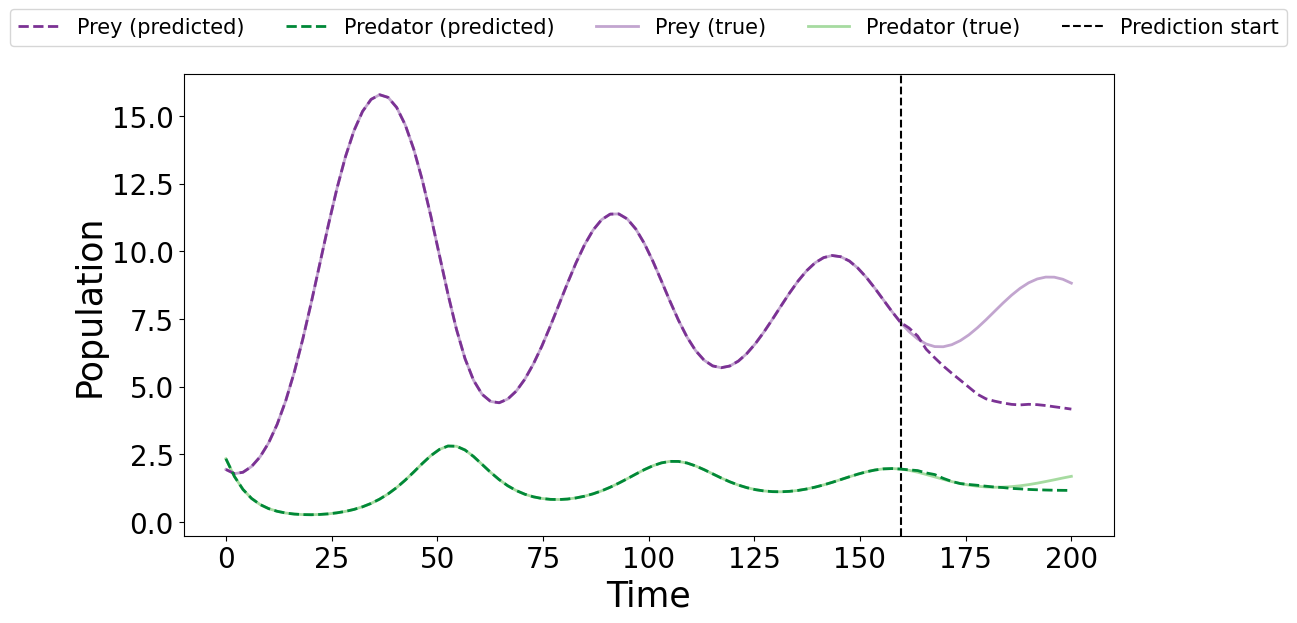

In [ ]:
# Test the model
model.eval()
with torch.no_grad():    
    for (batch,) in tqdm(test_loader_local):
        outputs = model.generate(batch, attention_mask = torch.ones_like(batch), max_new_tokens=max_ctx_length*2)
        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        prediction_decoded = decoding(prediction)
        break

test_decoded = decoding(test_texts_all[0])

colours = ['#7b3294', '#c2a5cf', '#a6dba0', '#008837']
_, _, time = get_dataset()
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time, prediction_decoded[0], label='Prey (predicted)', linestyle="--", zorder=100, color=colours[0], linewidth=2)
ax.plot(time, prediction_decoded[1], label='Predator (predicted)', linestyle="--", zorder=100, color=colours[3], linewidth=2)
ax.plot(time, test_decoded[0], label='Prey (true)', color=colours[1], linewidth=2)
ax.plot(time, test_decoded[1], label='Predator (true)', color=colours[2], linewidth=2)
ax.axvline(time[79], color='black', linestyle='--', label='Prediction start')
ax.set_xlabel('Time')
ax.set_ylabel('Population')
ax.legend(fontsize=15, ncol=5, bbox_to_anchor=(0.5, 1.1), loc='center')
plt.savefig(f'../plots/{lora_rank}_{learning_rate}_inspection.png')
plt.show()


In [ ]:
# Clean up
del model
del tokenizer
del optimizer
del train_loader_local
del val_loader_local
del test_loader_local
del accelerator
del train_losses
del val_losses
torch.cuda.empty_cache()